In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
! unzip face-expression-recognition-dataset.zip -d expressions

In [17]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pdb
# from datasets.emotions import EmotionDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2
import numpy as np

In [18]:
class EmotionDataset(object):
    def __init__(self, data_path='/content/expressions',classes=['angry','disgust','fear','happy','neutral','sad','surprise'], test=False):

        self.test = test
        if self.test:
            self.data_path = os.path.join(data_path,'validation')
        else:
            self.data_path = os.path.join(data_path,'train')
        self.classes = classes
        self.label_dict = self.get_label_indeces()
        self.data_dict = self.load_dataset()


    def get_label_indeces(self):
        label_dict = {}
        for i in range(len(self.classes)):
            label_dict.update({self.classes[i]:i})
        return label_dict

    def __getitem__(self, idx):
        image = self.load_image(idx)
        label = self.data_dict['label'][idx]
        image = np.rollaxis(image, 2, 0)
        image = image / 255
        return image, label

    def __len__(self):
        return len(self.data_dict['image_files'])
    
    def load_image(self, idx):
        image_file = self.data_dict['image_files'][idx]
        image = cv2.imread(image_file)

        return image
    


    def load_dataset(self):
        data_dict = {'image_files' : [],
                     'label': []
                    }
        for label in self.classes:
            label_folder = os.path.join(self.data_path,label)
            for filename in os.listdir(label_folder):
                f = os.path.join(label_folder, filename)
                # checking if it is a file
                if os.path.isfile(f):
                    data_dict['image_files'].append(f)
                    data_dict['label'].append(self.label_dict[label])

        return data_dict

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/expressions/images/'

train_dataset = EmotionDataset(data_path=data_dir, classes=['angry','disgust','fear','happy','neutral','sad','surprise'], test=False)
val_dataset = EmotionDataset(data_path=data_dir, classes=['angry','disgust','fear','happy','neutral','sad','surprise'], test=True)
# train_dataloader = DataLoader(train_dataset,batch_size=4,shuffle=True)
train_dataloader = DataLoader(train_dataset,batch_size=1024,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=1024,shuffle=False)
dataloaders = {'train' : train_dataloader,'val' : val_dataloader}
class_names = ['angry','disgust','fear','happy','neutral','sad','surprise']
dataset_sizes = {'train' : len(train_dataset),'val' : len(val_dataset)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        if epoch % 5 != 0:
          model.train()  # Set model to training mode
          phase = 'train'
        else:
          phase = 'val'
          model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in tqdm(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            model = model.float()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs.float())
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

Epoch 0/99
----------


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


val Loss: 2.4281 Acc: 0.1523
Epoch 1/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.07it/s]


train Loss: 2.0422 Acc: 0.1933
Epoch 2/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.09it/s]


train Loss: 1.9569 Acc: 0.2187
Epoch 3/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.06it/s]


train Loss: 1.9133 Acc: 0.2344
Epoch 4/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.07it/s]


train Loss: 1.8737 Acc: 0.2485
Epoch 5/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


val Loss: 1.8886 Acc: 0.2446
Epoch 6/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


train Loss: 1.8394 Acc: 0.2644
Epoch 7/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.96it/s]


train Loss: 1.8092 Acc: 0.2740
Epoch 8/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7827 Acc: 0.2901
Epoch 9/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


train Loss: 1.7636 Acc: 0.2968
Epoch 10/99
----------


100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


val Loss: 1.8184 Acc: 0.2717
Epoch 11/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


train Loss: 1.7594 Acc: 0.2987
Epoch 12/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7542 Acc: 0.3040
Epoch 13/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.03it/s]


train Loss: 1.7496 Acc: 0.3042
Epoch 14/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7450 Acc: 0.3078
Epoch 15/99
----------


100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


val Loss: 1.8040 Acc: 0.2808
Epoch 16/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.02it/s]


train Loss: 1.7401 Acc: 0.3100
Epoch 17/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.02it/s]


train Loss: 1.7362 Acc: 0.3115
Epoch 18/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.02it/s]


train Loss: 1.7324 Acc: 0.3127
Epoch 19/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7329 Acc: 0.3129
Epoch 20/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


val Loss: 1.7965 Acc: 0.2857
Epoch 21/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7302 Acc: 0.3150
Epoch 22/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7304 Acc: 0.3146
Epoch 23/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7292 Acc: 0.3162
Epoch 24/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.98it/s]


train Loss: 1.7282 Acc: 0.3170
Epoch 25/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


val Loss: 1.7941 Acc: 0.2857
Epoch 26/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7281 Acc: 0.3156
Epoch 27/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.91it/s]


train Loss: 1.7267 Acc: 0.3163
Epoch 28/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7270 Acc: 0.3160
Epoch 29/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7274 Acc: 0.3143
Epoch 30/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


val Loss: 1.7930 Acc: 0.2864
Epoch 31/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7262 Acc: 0.3163
Epoch 32/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


train Loss: 1.7262 Acc: 0.3170
Epoch 33/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7270 Acc: 0.3157
Epoch 34/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7261 Acc: 0.3167
Epoch 35/99
----------


100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


val Loss: 1.7916 Acc: 0.2876
Epoch 36/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7257 Acc: 0.3165
Epoch 37/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7257 Acc: 0.3165
Epoch 38/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.02it/s]


train Loss: 1.7259 Acc: 0.3185
Epoch 39/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7254 Acc: 0.3168
Epoch 40/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


val Loss: 1.7920 Acc: 0.2862
Epoch 41/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.02it/s]


train Loss: 1.7259 Acc: 0.3178
Epoch 42/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7259 Acc: 0.3155
Epoch 43/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7254 Acc: 0.3183
Epoch 44/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7258 Acc: 0.3193
Epoch 45/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


val Loss: 1.7923 Acc: 0.2866
Epoch 46/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7266 Acc: 0.3179
Epoch 47/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


train Loss: 1.7260 Acc: 0.3166
Epoch 48/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.92it/s]


train Loss: 1.7254 Acc: 0.3157
Epoch 49/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


train Loss: 1.7254 Acc: 0.3173
Epoch 50/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


val Loss: 1.7919 Acc: 0.2883
Epoch 51/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.02it/s]


train Loss: 1.7252 Acc: 0.3176
Epoch 52/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7250 Acc: 0.3166
Epoch 53/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7256 Acc: 0.3185
Epoch 54/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7251 Acc: 0.3179
Epoch 55/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


val Loss: 1.7920 Acc: 0.2863
Epoch 56/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


train Loss: 1.7258 Acc: 0.3158
Epoch 57/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7255 Acc: 0.3171
Epoch 58/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7249 Acc: 0.3177
Epoch 59/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.03it/s]


train Loss: 1.7265 Acc: 0.3163
Epoch 60/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


val Loss: 1.7919 Acc: 0.2867
Epoch 61/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.02it/s]


train Loss: 1.7266 Acc: 0.3182
Epoch 62/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


train Loss: 1.7258 Acc: 0.3180
Epoch 63/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7247 Acc: 0.3186
Epoch 64/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7262 Acc: 0.3156
Epoch 65/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


val Loss: 1.7924 Acc: 0.2876
Epoch 66/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


train Loss: 1.7257 Acc: 0.3173
Epoch 67/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7253 Acc: 0.3164
Epoch 68/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.91it/s]


train Loss: 1.7255 Acc: 0.3148
Epoch 69/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7250 Acc: 0.3183
Epoch 70/99
----------


100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


val Loss: 1.7916 Acc: 0.2871
Epoch 71/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


train Loss: 1.7262 Acc: 0.3147
Epoch 72/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


train Loss: 1.7255 Acc: 0.3172
Epoch 73/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.02it/s]


train Loss: 1.7265 Acc: 0.3152
Epoch 74/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7250 Acc: 0.3181
Epoch 75/99
----------


100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


val Loss: 1.7912 Acc: 0.2880
Epoch 76/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7256 Acc: 0.3167
Epoch 77/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7252 Acc: 0.3162
Epoch 78/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7259 Acc: 0.3163
Epoch 79/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7262 Acc: 0.3155
Epoch 80/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


val Loss: 1.7924 Acc: 0.2869
Epoch 81/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7260 Acc: 0.3165
Epoch 82/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7257 Acc: 0.3170
Epoch 83/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7256 Acc: 0.3176
Epoch 84/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7251 Acc: 0.3160
Epoch 85/99
----------


100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


val Loss: 1.7919 Acc: 0.2884
Epoch 86/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7255 Acc: 0.3174
Epoch 87/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.97it/s]


train Loss: 1.7254 Acc: 0.3176
Epoch 88/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


train Loss: 1.7254 Acc: 0.3163
Epoch 89/99
----------


100%|██████████| 29/29 [00:09<00:00,  2.91it/s]


train Loss: 1.7254 Acc: 0.3159
Epoch 90/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


val Loss: 1.7924 Acc: 0.2863
Epoch 91/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7259 Acc: 0.3185
Epoch 92/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7251 Acc: 0.3167
Epoch 93/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7250 Acc: 0.3178
Epoch 94/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


train Loss: 1.7254 Acc: 0.3189
Epoch 95/99
----------


100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


val Loss: 1.7920 Acc: 0.2873
Epoch 96/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7257 Acc: 0.3174
Epoch 97/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7259 Acc: 0.3169
Epoch 98/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7257 Acc: 0.3157
Epoch 99/99
----------


100%|██████████| 29/29 [00:09<00:00,  3.00it/s]


train Loss: 1.7253 Acc: 0.3176
Training complete in 13m 18s
Best val Acc: 0.288423


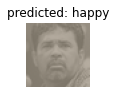

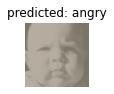

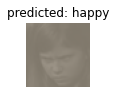

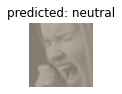

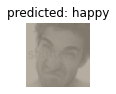

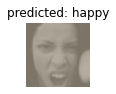

In [24]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.2)

######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# It should take around 15-25 min on CPU. On GPU though, it takes less than a
# minute.
#

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

######################################################################
#

visualize_model(model_ft)